# Reinforcement Learning Final Project

Student: **Ilan Francisco da Silva Theodoro** (ra257199)

For this project, we will implement and compare the performance of the following algorithms:
- Monte Carlo Control
- Sarsa($\lambda$)
- Q-Learning
- Deep Q-Learning

But first, we will implement a few helper functions and classes. Since there are a lot of redundancy between the algorithms, we will implement a base class for the control algorithms, and then we will implement the specific algorithms as subclasses of this base class. The same happens for the Q-functions, where we will implement a base class for the Q-functions, and then we will implement the specific Q-functions as subclasses of this base class.

### Installing dependencies

Firstly, we need to install the required packages:

In [24]:
!pip install gymnasium==0.29.1
!pip install scikit-learn==1.3.2
!pip install tqdm==4.66.1
!pip install numba==0.58.1
!pip install matplotlib==3.8.2


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
  Using cached matplotlib-3.8.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
Using cached matplotlib-3.8.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.4.3
    Uninstalling matplotlib-3.4.3:
      Successfully uninstalled matplotlib-3.4.3

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [13]:
!pip install gdown==4.7.1
import gdown

url = "https://drive.google.com/uc?id=1EDQdfQL8MmETSpaNC5_9P-tZ4Mmsqzap"
output = "results.pkl"
gdown.download(url, output, quiet=False)


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


Downloading...
From (uriginal): https://drive.google.com/uc?id=1EDQdfQL8MmETSpaNC5_9P-tZ4Mmsqzap
From (redirected): https://drive.google.com/uc?id=1EDQdfQL8MmETSpaNC5_9P-tZ4Mmsqzap&confirm=t&uuid=5e80194a-9748-4f30-abef-91e6809102ed
To: /data_lids/home/ilansilva/PycharmProjects/rl-final-project/notebooks/results.pkl
100%|██████████| 222M/222M [00:03<00:00, 60.6MB/s] 


'results.pkl'

### Environment state normalization

To start, we will implement a class to normalize the environment's state space. This is useful for the linear function approximation, as it will allow us to use the same weights for different environments.

It is a normalizer that scales the state space to the interval $[-1, 1]$. It is based on the following formula:

$$
\begin{align}
    \hat{x} &= \frac{2\sigma(x) + \sigma(x_{max}) + \sigma(x_{min})}{\sigma(x_{max}) - \sigma(x_{min})} \\
\end{align}
$$

Where $x_{max}$ and $x_{min}$ are the maximum and minimum values of the state space, respectively. $\sigma$ is the sigmoid function. This formula is applied to each dimension of the state space. It enforces that the state space is scaled to the interval $[-1, 1]$.

It is slightly different from how is calculated in the code. This happens because the above formula is a simplification that I got while I was writing this report. I got messy when I was writing the code kkkk.

In [1]:
"""This module contains the environment tools used in the project."""
import gymnasium as gym
import numpy as np
from scipy.special import expit as sigmoid


class EnvironmentNormalizer(gym.ObservationWrapper):
    """Normalized environment.

    This class is used to normalize the state of an environment according to a
    sigmoid function. It scales any observation value-range to the interval
    [-1, 1].
    """

    def __init__(self, env: gym.Env) -> None:
        """Creates a new normalized environment.

        :param env: the environment to be normalized.
        """
        super().__init__(env)
        self.observation_space = gym.spaces.Box(
            low=-1,
            high=1,
            shape=self.env.observation_space.shape,
            dtype=np.float32,
        )
        if isinstance(self.env.observation_space, gym.spaces.Box):
            self.scale_right = sigmoid(self.env.observation_space.high) - 0.5
            self.scale_left = sigmoid(self.env.observation_space.low) - 0.5
            self.mean = (self.scale_right + self.scale_left) / 2

    def observation(self, observation: np.ndarray) -> np.ndarray:
        """Normalized observation.

        :param observation: the observation to be normalized.
        :returns: the normalized observation.
        """
        return self._normalize(observation)

    def _normalize(self, obs: np.ndarray) -> np.ndarray:
        """Normalize the state according to a sigmoid function."""
        obs = sigmoid(obs) - 0.5
        obs = (obs - self.mean) / (self.scale_right - self.mean)
        return obs

    @staticmethod
    def from_gym(name_id: str) -> gym.Env:
        """Create a new normalized environment from gym.

        :param name_id: name of the environment in gym.
        :returns: a new normalized environment.
        """
        return EnvironmentNormalizer(gym.make(name_id))


### Q-functions

Now, we will implement the Q-functions. We will implement two Q-functions: one tabular and one linear. The tabular Q-function is the simplest one, and it is used as a baseline for the other Q-functions. The linear Q-function is a linear approximation of the tabular Q-function. It is used to reduce the number of parameters of the Q-function, which is useful for environments with large state spaces.

The most important methods of the Q-function are:
- `__call__`: returns the Q-value of a state-action pair.
- `update`: updates the Q-value of a state-action pair according to the
  update rule of the Q-function.
- `q_max`: returns the maximal Q-value for a given state, and the action
  associated with it. It is used to choose the action according to the greedy
    policy.

#### Tabular Q-function

The tabular Q-function is implemented as a numpy array since we know how many states the model has and the number of actions, because the environment is normalized and can be easily discretized.

In that sense, each state is discretized and directly mapped to the Q-value array. Each state dimension sum up to a new dimension in the Q-value array, in the sense that if $N$ is the number of possible values for a state in a dimension, then the Q-value array will have a shape of $(N, N, ..., N, A)$, where $A$ is the number of actions available in the environment.  

Each state dimension is discretized according to the following formula:

$$
\begin{align}
    \hat{x} &= \text{round}((x + 1) * \alpha) \\
\end{align}
$$

Where $\alpha$ is the discrete scale. It is a hyperparameter that defines the number of possible values for a state in a dimension. It is used to discretize the state space to a finite number of values. It is a trade-off between the number of states and the accuracy of the Q-function. The higher the discrete scale, the higher the number of states, and the higher the accuracy of the Q-function.

The state $x$ is summed with $1$ to ensure that the state is always positive. This is necessary because the state can be negative down to $-1$, and the index of the Q-value array must be positive. The state is multiplied by $\alpha$ to scale the state to the interval $[0, 2*\alpha]$. Then, the state is rounded to the nearest integer to get the index of the Q-value array. Hence, $N = 2*\alpha + 1$.

In [2]:
"""Q functions implementations for control algorithms.

author: Ilan Theodoro.
date: December/2023.
"""
from abc import ABC
from abc import abstractmethod
from typing import Any
from typing import List
from typing import Optional
from typing import Union

import numpy as np
import torch


class QTabular:
    """Discretized tabular Q state-action-value function."""

    def __init__(
        self, n_actions: int, n_feat: int, discrete_scale: float = 40.0
    ) -> None:
        """Define a tabular Q function.

        :param n_actions: number of actions available in the environment.
        :param n_feat: number of features in the state.
        :param discrete_scale: scale in which the state will be discretized. The
         state will be multiplied by this number and then rounded to the nearest
         integer.
        """
        self._q = np.zeros(
            (*[discrete_scale * 2 + 1] * n_feat, n_actions), dtype=np.float32
        )
        self._n = np.zeros(
            (*[discrete_scale * 2 + 1] * n_feat, n_actions), dtype=np.float32
        )

        self.n_actions = n_actions
        self.n_feat = n_feat
        self.count_non_zero = 0
        self.discrete_scale = discrete_scale

    def __call__(self, state: np.ndarray, action: int) -> float:
        """Call function to get the Q value of a state-action pair."""
        state = self._preprocess_state(state)
        idx = self._index(state, action)
        return self._q[idx].item()

    @property
    def states_explored(self) -> int:
        """Number of states explored."""
        return self.count_non_zero

    def q_max(self, state: np.ndarray) -> tuple[int, float]:
        """Maximal Q value for a given state.

        Get the action and Q value for the maximal Q value for a given
        state.

        :param state: state to be evaluated.
        :return: action and Q value for the maximal Q value for a given state.
        """
        state = self._preprocess_state(state)
        idx_state = self._index(state)

        maximal_value = -np.inf
        maximal_set = []
        for action in range(self.n_actions):
            if maximal_value < self._q[idx_state][action]:
                maximal_value = self._q[idx_state][action]
                maximal_set = [action]
            elif maximal_value == self._q[idx_state][action]:
                maximal_set.append(action)

        action = np.random.choice(maximal_set)

        return action, maximal_value

    def update(
        self,
        state: np.ndarray,
        action: int,
        expected: float,
        _: float,
        α: float,
    ) -> None:
        """Update the Q value for a given state-action pair.

        It is a classical update rule for a tabular Q function. The update rule
        follows the principle of minimizing the error between the expected and
        the predicted value.

        :param state: state associated.
        :param action: action associated.
        :param expected: expected value for the evaluated policy.
        :param _: ignored.
        :param α: learning rate.
        """
        predicted = self(state, action)
        state = self._preprocess_state(state)
        idx = self._index(state, action)
        if self._n[idx] == 0:
            self.count_non_zero += 1
        self._n[idx] += α
        self._q[idx] += α * (expected - predicted)

    def n(self, state: np.ndarray, action: Optional[int] = None) -> float:
        """Number of times a state or a state-action pair was visited.

        :param state: state to be evaluated.
        :param action: action to be evaluated. If None, returns the number of
         times the state was visited.
        :return: number of times a state or a state-action pair was visited.
        """
        state = self._preprocess_state(state)
        idx = self._index(state)
        return np.sum(self._n[idx]) if action is None else self._n[idx][action]

    def _preprocess_state(self, state: np.ndarray) -> np.ndarray:
        """Preprocess the state to be used in the tabular Q function."""
        if not np.issubdtype(state.dtype, np.integer):
            state = self._discretize(state)

        return state

    def _index(self, state: np.ndarray, action: Optional[int] = None) -> tuple:
        """Get the index of a state or a state-action pair.

        It is solved according to the injective mapping of a state the index
        in the Q table.

        :param state: state to be evaluated.
        :param action: action to be evaluated. If None, returns the index of the
         state.
        :return: index of a state or a state-action pair.
        """
        state_idx = state + self.discrete_scale
        if any(state_idx < 0):
            raise ValueError("Index is negative")
        if action is None:
            idx = tuple(state_idx)
        else:
            idx = tuple(state_idx) + (action,)
        return idx

    def _discretize(self, state: np.ndarray) -> np.ndarray:
        """Discretize the state.

        :param state: state to be discretized. It must be a numpy array.
        """
        state = (state * self.discrete_scale).astype(int)
        return state


#### Linear Q-function

The linear Q-function is a linear approximation of the tabular Q-function. It is defined as $Q(s) = W^T x(s)$, where $W$ is the weight vector mapping the state space to the action space and $x(s)$ is the input sample from the state space.

The code below has a QAbstractApproximation since it is used as a base class for the linear Q-function and the DQN Q-function. Which we are going to implement later.

It is important noting that even a Linear Q-function wraps a tabular Q-function, since it is important to store the number of times a state-action pair was visited. This is necessary in several occasions that we will face throughout this report.

In [3]:
class QAbstractApproximation(ABC):
    """Abstract class for Q function approximations."""

    def __init__(
        self, n_actions: int, n_feat: int, discrete_scale: int = 40
    ) -> None:
        """Define generic Q function approximation.

        It includes a tabular Q function in cases where discrete evaluation is
        necessary.

        :param n_actions: number of actions available in the environment.
        :param n_feat: number of features in the state.
        :param discrete_scale: scale in which the state will be discretized. The
         state will be multiplied by this number and then rounded to the nearest
         integer.
        """
        self.n_actions = n_actions
        self.n_feat = n_feat
        self.q_tabular = QTabular(n_actions, n_feat, discrete_scale)

    @abstractmethod
    def __call__(
        self, state: np.ndarray, action: Optional[int] = None
    ) -> Union[np.ndarray, torch.Tensor]:
        """Call function to get the Q value of a state-action pair."""
        raise NotImplementedError

    def q_max(self, state: np.ndarray) -> tuple[int, float]:
        """Maximal Q value for a given state.

        Get the action and Q value for the maximal Q value for a given state.

        :param state: state to be evaluated.
        :return: action and Q value for the maximal Q value for a given state.
        """
        values = self(state)
        if isinstance(values, torch.Tensor):
            values = values.detach().cpu().numpy().astype(np.float32)
        maximal_value = values.max()
        maximal_set = np.argwhere(values == maximal_value).flatten()
        action = np.random.choice(maximal_set)

        return action, maximal_value.item()

    def __getattr__(self, name: str) -> Any:
        """Get missing attributes from the tabular Q function."""
        return getattr(self.q_tabular, name)


class QLinear(QAbstractApproximation):
    """Linear Q function value approximation."""

    def __init__(
        self, base_lr: float = 0.0001, *args: Any, **kwargs: Any
    ) -> None:
        """Define a linear Q function approximation.

        It is an unbiased linear approximation of the Q function. It is defined
        as Q(s) = W^T x(s), where W is the weight vector mapping the state
        space to the action space and x(s) is the input sample from the state
        space.

        :param base_lr: base learning rate to scale the learning rate of the
         control algorithm.
        :param args: arguments to be passed to the QAbstractApproximation.
        :param kwargs: keyword arguments to be passed to the
         QAbstractApproximation.
        """
        super().__init__(*args, **kwargs)
        self.base_lr = base_lr
        self.weights = np.zeros((self.n_feat, self.n_actions))

    def __call__(
        self, state: np.ndarray, action: Optional[int] = None
    ) -> np.ndarray:
        """Call function to get the Q value of a state-action pair."""
        x = np.asarray(state)
        y = self.weights.T @ x
        return y[action] if action is not None else y

    def update(
        self,
        state: np.ndarray,
        action: int,
        expected: float,
        _: float,
        α: float,
    ) -> None:
        """Update the Q linear approximation for a given state-action pair.

        It is a classical update rule for a linear Q function approximation. The
        update rule follows the principle of minimizing the error between the
        expected and the predicted value.

        :param state: state associated.
        :param action: action associated.
        :param expected: expected value for the evaluated policy.
        :param _: ignored
        :param α: learning rate.
        """
        predicted = self(state, action).item()
        self.q_tabular.update(state, action, expected, predicted, α)
        α *= self.base_lr

        self.weights[:, action] += (
            α * (expected - predicted) * np.asarray(state)
        )

### Agent definition

The agent is just a wrapper for the Q-function. It is used to choose an action based on the current state. The action is chosen using an epsilon-greedy strategy.

Mainly there are two epsilon-greedy strategies. The first is the one used in the DQN paper, which is defined as $\epsilon = 0.05 + 0.85 * e^{-steps\_done / 1000}$. The second is the one requested by the final project specification, which is defined as $\epsilon = N_0 / (N_0 + N(s))$, where $N_0$ is a hyperparameter and $N(s)$ is the number of times the state $s$ has been visited.

It also has defined a stochasticity factor, which is a hyperparameter that defines the stochasticity of the agent. The action is chosen randomly with probability equal to the stochasticity factor. Otherwise, the action is chosen according to the epsilon-greedy strategy.

In [4]:
"""Agent class definition."""
from typing import Callable
from typing import Optional
from typing import Union

import numpy as np
import torch


class Agent:
    """Agent class based on a ϵ-greedy policy."""

    def __init__(
        self,
        q_function: Union[QTabular, QAbstractApproximation],
        n_actions: int,
        eps_greedy_function: str = "dqn",
        n0: Optional[float] = None,
        stochasticity_factor: float = 0.0,
    ) -> None:
        """Agent class.

        Define an agent that chooses an action based on the current state.
        The action is chosen using an epsilon-greedy strategy.

        :param q_function: Q function used to choose the action.
        :param n0: parameter used in the epsilon-greedy function.
        :param n_actions: number of actions available in the environment.
        :param eps_greedy_function: string that defines the epsilon-greedy
         function. The options are:
         - "s": epsilon is a function of the number of times the state has
         been visited. Defined as N_0 / (N_0 + N(s)), where N(s) is the number
         of times the state s has been visited.
         - "t": epsilon is a function of the number of episodes. Defined as
         N_0 / (N_0 + t), where t is the current episode.
         - "dqn": epsilon is a function of the  number of steps as used in
         the DQN paper. Defined as 0.05 + 0.85 * exp(-steps_done / 1000).
        :param stochasticity_factor: factor that defines the stochasticity of
         the agent. The action is chosen randomly with probability equal to
         stochasticity_factor.
        """
        self.q_function = q_function
        self.stochasticity_factor = stochasticity_factor

        self.ϵ: Callable[[np.ndarray, int], float]

        if eps_greedy_function == "dqn" and n0 is not None:
            raise ValueError(
                "N0 is not defined when using the DQN epsilon function"
            )
        elif eps_greedy_function != "dqn" and n0 is None:
            raise ValueError(
                "N0 must be defined when using a custom epsilon function"
            )

        if eps_greedy_function == "s":
            self.ϵ = lambda s, t: n0 / (n0 + self.q_function.n(s))  # type: ignore
        elif eps_greedy_function == "t":
            self.ϵ = lambda s, t: n0 / (n0 + t)  # type: ignore
        elif eps_greedy_function == "dqn":
            self.ϵ = lambda *_: 0.05 + 0.85 * np.exp(  # type: ignore
                -self.steps_done / 1000
            )
        else:
            raise ValueError("Unknown epsilon function")

        self.n_actions = n_actions
        self.steps_done = 0

    def act(self, state: np.ndarray, current_episode: int) -> int:
        """Agent action.

        Choose an action based on the current state.
        The action is chosen using an epsilon-greedy strategy.

        :param state:
            current state.
        :param current_episode:
            current episode.
        :return:
            action chosen.
        """
        self.steps_done += 1
        # ϵ-greedy strategy to choose the action
        t = np.random.uniform()
        s = np.random.uniform()
        if t > self.ϵ(state, current_episode) and s > self.stochasticity_factor:
            with torch.no_grad():
                action, best_reward = self.q_function.q_max(state)
            return action
        else:
            return np.random.randint(self.n_actions)


### Replay memory

Here, I am going to define the replay memory. It is used to store the transitions of the agent. It is used to break the correlation between the samples, which is important for the learning process. It is also used to store the transitions of the agent, which is useful for the DQN algorithm.

Although not required in the project specification, it can be used to store the transitions of the agent in the other algorithms. Such as Q-Learning, Monte-Carlo and Sarsa-Lambda. However, I do not plan to use it in these algorithms. I will use it only in the DQN algorithm. To ensure generalization, I am going to use those algorithms with a batch size valued None, which means that the algorithm will consume and release the transitions in the replay memory as soon as they are available. This way, the replay memory will not be used in these algorithms.

In [5]:
"""Replay Memory implementation as described in DQN paper.

author: Ilan Theodoro.
date: December/2023.
"""
from collections import deque
from random import sample
from typing import Any, Optional


class ReplayMemory:
    """Replay memory as described in the DQN paper."""

    def __init__(self, capacity: int, batch_size: Optional[int]) -> None:
        """Initialize the replay memory.

        :param capacity: The maximum number of transitions to be saved.
        :param batch_size: The batch size to be sampled.
        :param consume_and_release: Whether to consume and release the memory.
        """
        self.memory: deque = deque([], maxlen=capacity)
        if batch_size is None:
            self.consume_and_release = True
            self.batch_size = 1
        else:
            self.consume_and_release = False
            self.batch_size = batch_size

    def push(self, *args: Any) -> None:
        """Save a transition.

        :param args: The transition to be saved.
        """
        self.memory.append(args)

    @property
    def batch_ready(self) -> bool:
        """Whether the batch is ready.

        :return: Whether the batch is ready.
        """
        return len(self.memory) >= self.batch_size

    def sample(self) -> list:
        """Sample a batch according to the batch size.

        :return: A batch of transitions.
        """
        if not self.batch_ready:
            raise RuntimeError(
                "The batch is not ready. There are not enough " "transitions."
            )
        if self.consume_and_release:
            ret = [self.memory.popleft() for _ in range(self.batch_size)]
            return ret
        else:
            return sample(self.memory, self.batch_size)


### Control algorithms

#### Abstract Control

It wraps most of the control logic algorithm and defines the interface for the control algorithms. It is used as a base class for the control algorithms.

The main components of the control algorithm are:
- `fit`: the main loop of the control algorithm. It iterates over the episodes
  and the steps of each episode. It calls the `update_on_step` and
  `update_on_episode_end` methods, which can be implemented by the children
  classes.
- `update_on_step`: update the agent on a step. It is called on each step of
    the episode. It is used by the Q-Learning, and Sarsa-Lambda.
- `update_on_episode_end`: update the agent on an episode end. It is called on
    each episode end. It is used by the Monte-Carlo.
- `reset`: reset the control algorithm. It is called on each episode. It is useful
    if the control algorithm needs to reset some internal state. It is used by
    the Sarsa-Lambda.
- `optimize`: optimize the Q-function. It can be called by the children classes
    to optimize the Q-function. However, when the function is different from 
    the conceptual update rule adopted by the control algorithm, it must be 
    overridden by the children classes. Such as the case of the Sarsa-Lambda.

In [6]:
"""Control algorithms for reinforcement learning."""
from abc import ABC
from abc import abstractmethod
from functools import partial
from typing import Any
from typing import Callable
from typing import Optional
from typing import Union

import gymnasium as gym
import numba
import numpy as np
from torch import Tensor

from numba import jit


try:
    # Attempt to import the IPython module
    from IPython import get_ipython

    # Check if the code is running in a Jupyter notebook
    if "IPKernelApp" in get_ipython().config:
        # Import the tqdm notebook module
        from tqdm.notebook import tqdm
except Exception:
    # If it fails, import the terminal version of tqdm
    from tqdm import tqdm


class AbstractControl(ABC):
    """Abstract class for control algorithms."""

    def __init__(
        self,
        env: gym.Env,
        agent: Agent,
        gamma: float,
        replay_capacity: int = 10000,
        num_episodes: int = 1000,
        batch_size: Optional[int] = 32,
        reward_mode: str = "default",
        verbose: bool = True,
    ) -> None:
        """Default constructor for the AbstractControl class.

        :param env: The gym environment.
        :param agent: The agent.
        :param replay_capacity: The replay capacity for the replay memory.
        :param num_episodes: The number of episodes in which the algorithm will
         learn.
        :param gamma: The discount factor.
        :param batch_size: The batch size for the replay memory.
        :param reward_mode: The reward mode. It can be 'default' or 'sparse'. In
         the 'default' mode, the reward is the reward received from the
         environment. In the 'sparse' mode, the reward is the total reward
         received in the episode.
        :param verbose: Whether to print the progress bar.
        """
        self.env = env
        self.verbose = verbose
        self.agent = agent
        self.num_episodes = num_episodes
        self.q_function = agent.q_function
        self.γ = gamma
        self.α_t: Callable[[np.ndarray, int], float] = (
            lambda s, a: 1 / self.q_function.n(s, a)
            if self.q_function.n(s, a) > 0
            else 1
        )
        self.memory = ReplayMemory(replay_capacity, batch_size)

        self.reward_processor: Callable[[float, bool, float], float]
        if reward_mode == "default":
            self.reward_processor = lambda r, *_: r
        elif reward_mode == "sparse":
            self.reward_processor = (
                lambda _, done, total_reward: total_reward if done else 0
            )
        else:
            raise ValueError(
                f"Invalid reward mode. Expected 'default' or 'sparse', got "
                f"{reward_mode}"
            )

    def fit(self) -> list[float]:
        """Fitting loop for the control algorithm.

        It is built according to a generic reinforcement learning loop that
        iterates over the episodes and the steps of each episode. The children
        classes must implement the update_on_step and update_on_episode_end
        methods, in which they can control how the agent learns.

        :return: The mean of the last 10% of the episodes.
        """
        episodes_rewards = []

        pbar = tqdm(range(self.num_episodes), disable=not self.verbose)
        for i_episode in pbar:
            state, _ = self.env.reset(seed=i_episode)
            action = self.agent.act(state, current_episode=i_episode)
            returns = []
            total_reward = 0.0
            self.reset()
            while True:
                state_prime, reward, done, truncated, info = self.env.step(
                    action
                )
                reward = float(reward)
                total_reward += reward
                reward_processed = self.reward_processor(
                    reward, done, total_reward
                )
                returns.append((state, action, reward_processed))

                action_prime = self.agent.act(
                    state_prime, current_episode=i_episode
                )
                loss_updated = self.update_on_step(
                    state,
                    action,
                    reward_processed,
                    state_prime if not done else None,
                    action_prime,
                    done,
                )
                if loss_updated is not None:
                    pbar.set_postfix(loss=loss_updated)

                if done or truncated:
                    loss_updated = self.update_on_episode_end(returns)
                    if loss_updated is not None:
                        pbar.set_postfix(loss=loss_updated)

                    episodes_rewards.append(total_reward)
                    moving_average = np.mean(episodes_rewards[-100:])

                    pbar.set_description(
                        f"Total reward for episode {i_episode:3d}: "
                        f"{total_reward}, moving average: {moving_average:.2f},"
                        f" states explored: {self.q_function.states_explored}",
                        refresh=False,
                    )
                    break

                state = state_prime
                action = action_prime

        return episodes_rewards

    @abstractmethod
    def update_on_step(
        self,
        state: np.ndarray,
        action: int,
        reward: float,
        state_prime: np.ndarray,
        action_prime: int,
        done: bool,
    ) -> Optional[float]:
        """Abstract method to update the agent on a step."""
        pass

    @abstractmethod
    def update_on_episode_end(self, returns: list) -> Optional[float]:
        """Abstract method to update the agent on an episode end."""
        pass

    def reset(self) -> None:  # noqa: B027
        """Reset the control algorithm."""
        pass

    def optimize(self) -> Optional[float]:
        """Generic optimization of the policy network.

        It follows the rule that generally the optimization goal is designed
        to minimize the difference between the expected and the predicted
        value. It is performed on a batch of samples from the replay memory.

        :return: The loss of the optimization step. If no optimization step was
         performed, returns None.
        """
        if self.memory.batch_ready:
            batch = self.memory.sample()
            loss = 0
            updated_batch = []
            for b in batch:
                s, a, y_callable, _, α = b
                if isinstance(y_callable, Callable):  # type: ignore
                    y = y_callable()
                else:
                    y = y_callable
                updated_batch.append((s, a, y, _, α))

            for ub in updated_batch:
                _loss = self.q_function.update(*ub)
                if _loss is not None:
                    loss += _loss
            return loss / len(batch)
        else:
            return None

#### Monte-Carlo Control

The Monte-Carlo control algorithm is implemented as a subclass of the AbstractControl class. It implements the update_on_episode_end method, which is used to update the agent on an episode end. 

The target learning is to predict $G_t = R_{t+1} + \gamma R_{t+2} + ... + \gamma^{T-1} R_T$, where $T$ is the last time step of the episode. 

The update rule is defined as $Q(S_t, A_t) = Q(S_t, A_t) + \alpha (G_t - Q(S_t, A_t))$, where $\alpha$ is the learning rate.

In [7]:

class MonteCarloControl(AbstractControl):
    """Monte Carlo control algorithm implementation."""

    def update_on_step(self, *_: Any) -> Optional[float]:
        """Dummy method to avoid abstraction unimplemented error."""
        pass

    def update_on_episode_end(self, returns: list) -> Optional[float]:
        """Feedback the agent with the returns."""
        gt = 0
        count = 0
        for state, action, reward in reversed(returns):
            gt = self.γ * gt + reward

            # Update the mean for the action-value function Q(s,a)
            self.memory.push(state, action, gt, None, self.α_t(state, action))
            count += 1

        if self.memory.consume_and_release:
            # workaround a.k.a gambiarra
            old_batch_size = self.memory.batch_size
            self.memory.batch_size = count
            ret = self.optimize()
            self.memory.batch_size = old_batch_size
            return ret
        else:
            return self.optimize()

#### Q-Learning Control

The Q-Learning control algorithm is implemented as a subclass of the AbstractControl class. It implements the update_on_step method, which is used to update the agent on a step.

The target learning is to predict $R_{t+1} + \gamma \max_a Q(S_{t+1}, a)$. The expected value is evaluated based on the current policy, which can vary over time. Hence, does not make sense to store the expected value in the replay memory. Instead, we store a callable that returns the expected value. This way, we can evaluate the expected value at the time of the optimization step.

In [8]:
class QLearningControl(AbstractControl):
    """Q-Learning control algorithm implementation."""

    def update_on_step(
        self,
        state: np.ndarray,
        action: int,
        reward: float,
        next_state: np.ndarray,
        _: Any,
        done: bool,
    ) -> Optional[float]:
        """Feedback the agent with the transitions on a determined step.

        :param state: The current state
        :param action: The action taken
        :param reward: The reward received
        :param next_state: The next state
        :param _: ignored
        :param done: Whether the episode is over

        :return: The loss of the optimization step. If no optimization step was
         performed, returns None.
        """
        # Compute the max Q(s',a')
        max_q = partial(self.q_function.q_max, next_state)

        # Compute a dynamic expected value according to the done flag and the
        # max Q(s',a')
        def expected(
            r: float, done: bool, max_q: Callable
        ) -> Callable[[], float]:
            return lambda: r + self.γ * max_q()[1] if not done else r

        self.memory.push(
            state,
            action,
            expected(reward, done, max_q),
            None,
            self.α_t(state, action),
        )

        return self.optimize()

    def update_on_episode_end(self, *_: Any) -> None:
        """Dummy method to avoid abstraction unimplemented error."""
        pass

#### Sarsa-Lambda Control

Sarsa-lambda is tricky.

The tabular version of the algorithm is implemented as described in the book. The linear version is the "true online sarsa($\lambda$)" implemented as described in the book "Reinforcement Learning: An Introduction" by Sutton and Barto.

For the tabular version, I had to optimize the code using the feature of just-in-time compilation provided by the package numba.

In [9]:
@jit(nopython=True)
def _sarsa_update_q_function(n: np.ndarray, q: np.ndarray, etrace: dict, α: float, δ: float, γ: float, λ: float) -> None:
    """Update the Q function for the Sarsa algorithm."""
    for i, e in etrace.items():
        n[i] += α * e
        q[i] += α * δ * e
        etrace[i] *= γ * λ


class SarsaLambdaControl(AbstractControl):
    """Sarsa control algorithm implementation."""

    def __init__(self, lambda_factor: float, *args: Any, **kwargs: Any) -> None:
        """Constructor for the Sarsa control algorithm.

        :param lambda_factor: The lambda factor for the eligibility trace.
        :param args: remaining arguments from :AbstractControl:
         `rl_final_project.AbstractControl.__init__`
        :param kwargs: remaining keyword arguments
        """
        super().__init__(*args, **kwargs)
        self.λ = lambda_factor
        self.e = numba.typed.Dict()
        self.q_old = 0
        self.z = np.zeros(self.q_function.n_feat)

    def update_on_step(
        self,
        state: np.ndarray,
        action: int,
        reward: float,
        next_state: np.ndarray,
        next_action: int,
        done: bool,
    ) -> None:
        """Feedback the agent with the returns."""

        def q_prime_instantiation(
            next_state: np.ndarray, next_action: int
        ) -> Callable:
            return (
                lambda: self.q_function(next_state, next_action)
                if next_state is not None
                else 0
            )

        q_prime = q_prime_instantiation(next_state, next_action)

        def q_instantiation(
            s: np.ndarray, a: int
        ) -> Callable[[], Union[float, np.ndarray, Tensor]]:
            return lambda: self.q_function(s, a)

        q = q_instantiation(state, action)

        def δ_instantiation(
            r: float, q_prime_call: Callable, q_call: Callable
        ) -> Callable[[], float]:
            return lambda: r + self.γ * q_prime_call() - q_call()

        δ = δ_instantiation(reward, q_prime, q)

        s = self.q_function._preprocess_state(state)
        idx = self.q_function._index(s, action)
        α = self.α_t(state, action)

        # self.memory.push(S, A, q_prime, q, δ, self.α_t(S, A))

        if isinstance(self.q_function, QLinear):
            x = np.asarray(state)
            self.z = (
                self.γ * self.λ * self.z
                + (1 - α * self.γ * self.λ * self.z.T @ x) * x
            )
            self.q_function.weights[:, action] += (
                α * 0.1 * (δ() + q() - self.q_old) * self.z
                - α * (q() - self.q_old) * x
            )
            self.q_function.q_tabular._n[idx] += 1
            self.q_function.q_tabular.count_non_zero += 1
            self.q_old = q_prime()
        elif isinstance(self.q_function, QTabular):
            self.memory.push(
                state, action, q_prime, q, δ, self.α_t(state, action)
            )
            self.optimize()
        else:
            raise NotImplementedError

    def optimize(self) -> None:
        """Optimize the policy network.

        It is applied the tabular version of the algorithm.
        """
        if isinstance(self.q_function, QTabular):
            if self.memory.batch_ready:
                batch = self.memory.sample()
                updated_batch = []
                for b in batch:
                    s, a, q_prime, q, δ, α = b
                    updated_batch.append((s, a, q_prime(), q(), δ(), α))

                for ub in updated_batch:
                    s, a, q_prime, q, δ, α = ub
                    s = self.q_function._preprocess_state(s)
                    idx = self.q_function._index(s, a)

                    if idx not in self.e:
                        self.e[idx] = 0.0
                        self.q_function.count_non_zero += 1

                    # compiled code for fast update
                    _sarsa_update_q_function(self.q_function._n, self.q_function._q, self.e, α, δ, self.γ, self.λ)

        return None

    def update_on_episode_end(self, *_: Any) -> None:
        """Dummy method to avoid abstraction unimplemented error."""
        pass

    def reset(self) -> None:
        """Reset the control algorithm."""
        self.q_old = 0
        self.z = np.zeros(self.q_function.n_feat)


## DQN algorithm

I implemented the DQN algorithm in the framework of the control algorithms. 



In [10]:
"""Deep Q Network implementation.

The code is based on the following sources:
- https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
"""
from typing import Any
from typing import Optional

import numpy as np
import torch
import torch.nn.functional as F
from torch import nn


class DQN(nn.Module):
    """Deep Q Network Torch Module."""

    def __init__(self, n_observations: int, n_actions: int) -> None:
        """Deep Q Network.

        Implements a simple MLP with 2 hidden layers with 128 neurons each.

        :param n_observations: Number of observations
        :param n_actions: Number of actions
        """
        super().__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the network."""
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


class DQNFunction(QAbstractApproximation):
    """Deep Q Network Q Function Approximation."""

    def __init__(self, batch_size: int, *args: Any, **kwargs: Any) -> None:
        """Deep Q Network Q Function Approximation.

        :param batch_size: Batch size
        :param args: Remaining arguments for the QAbstractApproximation
        :param kwargs: Remaining keyword arguments for the
         QAbstractApproximation
        """
        super().__init__(*args, **kwargs)
        self.batch_size = batch_size
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        self.policy = DQN(self.n_feat, self.n_actions).to(self.device)
        self.target = DQN(self.n_feat, self.n_actions).to(self.device)
        self.target.load_state_dict(self.policy.state_dict())

    def __call__(
        self, state: np.ndarray, action: Optional[int] = None
    ) -> torch.Tensor:
        """Forward pass of the network.

        It converts the state to a torch tensor and passes it to the network.
        If an action is provided, it returns the Q value for that action.

        :param state: The state to evaluate
        :param action: The action to evaluate
        :return: The Q value for the state-action pair or the Q values for all
         actions if no action is provided
        """
        state_tsr = torch.tensor(state, dtype=torch.float32, device=self.device)
        if action is not None:
            return self.policy(state_tsr)[action]
        else:
            return self.policy(state_tsr)


class DQNControl(AbstractControl):
    """DQN Control algorithm.

    Implements the DQN algorithm as described in the paper:
    https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf
    """

    def __init__(
        self, lr: float, tau: float, *args: Any, **kwargs: Any
    ) -> None:
        """Constructor for the DQN control algorithm.

        :param lr: Learning rate
        :param tau: Soft update parameter
        :param args: remaining arguments
        :param kwargs: remaining keyword arguments
        """
        super().__init__(*args, **kwargs)
        if not isinstance(self.q_function, DQNFunction):
            raise ValueError("Q function must be a DQN")
        self.device = self.q_function.device
        self.policy = self.q_function.policy
        self.target = self.q_function.target
        self.optimizer = torch.optim.AdamW(
            self.policy.parameters(), lr=lr, amsgrad=True
        )
        self.τ = tau
        self.criteria = nn.SmoothL1Loss()

    def update_on_episode_end(self, returns: list) -> Optional[float]:
        """Feedback the agent with the returns."""
        pass

    def update_on_step(
        self,
        state: np.ndarray,
        action: int,
        reward: float,
        next_state: np.ndarray,
        next_action: int,
        done: bool,
    ) -> Optional[float]:
        """Feedback the agent with the transitions on a determined step.

        :param state: The current state
        :param action: The action taken
        :param reward: The reward received
        :param next_state: The next state
        :param next_action: The next action
        :param done: Whether the episode is over
        :return: The loss of the optimization step.
        """
        self.memory.push(state, action, next_state, reward)

        loss = self.optimize()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = self.target.state_dict()
        policy_net_state_dict = self.policy.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[
                key
            ] * self.τ + target_net_state_dict[key] * (1 - self.τ)
        self.target.load_state_dict(target_net_state_dict)

        return loss

    def optimize(self) -> Optional[float]:
        """Optimize the policy network.

        :return: The loss of the optimization step. If no optimization step was
         performed, returns None.
        """
        if self.memory.batch_ready:
            batch = self.memory.sample()

            s_lst = []
            a_lst = []
            r_lst = []
            s_next_lst = []
            for b in batch:
                sb, sa, sb_prime, rb = b
                s_lst.append(sb)
                a_lst.append(sa)
                r_lst.append(rb)
                s_next_lst.append(sb_prime)

            s = torch.tensor(s_lst, dtype=torch.float32, device=self.device)
            a = torch.tensor(
                a_lst, dtype=torch.int64, device=self.device
            ).unsqueeze(0)
            r = torch.tensor(r_lst, dtype=torch.float32, device=self.device)

            all_indices = torch.arange(
                self.memory.batch_size, device=self.device
            )
            state_action_values = (
                self.policy(s)[all_indices, a].squeeze(0).unsqueeze(1)
            )

            non_final_mask = torch.tensor(
                [False if s is None else True for s in s_next_lst],
                device=self.device,
                dtype=torch.bool,
            )
            non_final_next_states = torch.tensor(
                [s for s in s_next_lst if s is not None]
            ).to(self.device)
            next_state_values = torch.zeros(
                self.memory.batch_size, device=self.device
            )
            with torch.no_grad():
                next_state_values[non_final_mask] = (
                    self.target(non_final_next_states).max(1).values
                )

            # Compute the expected Q values
            expected_state_action_values = (next_state_values * self.γ) + r
            loss = self.criteria(
                state_action_values, expected_state_action_values.unsqueeze(1)
            )

            # Optimize the model
            self.optimizer.zero_grad()
            loss.backward()
            # In-place gradient clipping
            torch.nn.utils.clip_grad_value_(self.policy.parameters(), 100)
            self.optimizer.step()

            return loss.detach().item()

        return None


#### Simple run

Using Monte-Carlo with linear VFA.

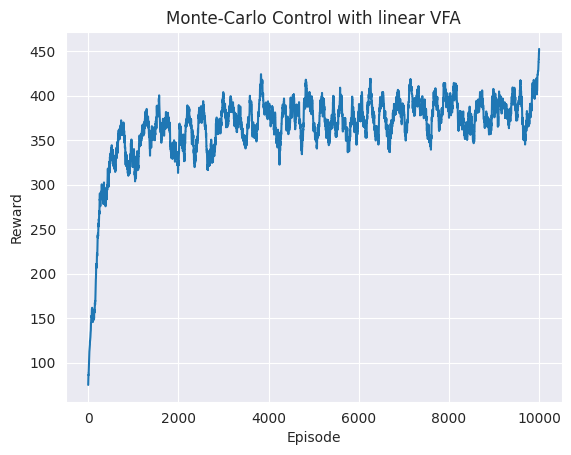

In [51]:
env = EnvironmentNormalizer.from_gym("CartPole-v1")
n_states = env.observation_space.shape[0]

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    # add padding to the signal
    y = np.pad(y, (box_pts//2, box_pts-1-box_pts//2), mode='edge')
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

q_function = QLinear(
    n_actions=env.action_space.n, 
    n_feat=n_states, 
    discrete_scale=10
)

agent = Agent(
    q_function,
    n0=5,
    n_actions=env.action_space.n,
    eps_greedy_function="s",
    stochasticity_factor=0.0,
)

control = MonteCarloControl(
    env, agent, num_episodes=10_000, gamma=0.5, batch_size=None, reward_mode="default"
)

eps_rewards = control.fit()
eps_rewards = smooth(eps_rewards, 100)

# plot the results
import matplotlib.pyplot as plt
plt.plot(eps_rewards)
plt.title("Monte-Carlo Control with linear VFA")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

## DQN
Now with DQN

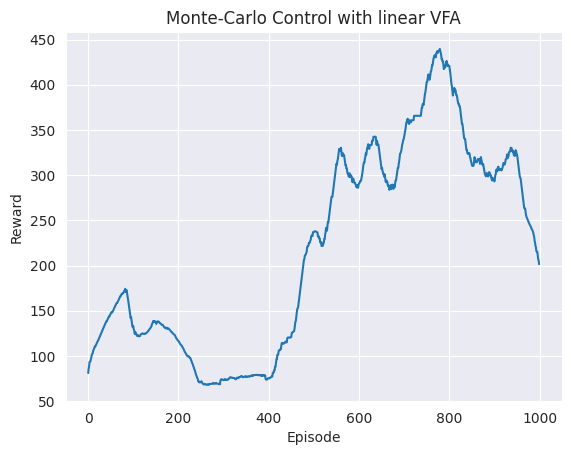

In [12]:
env = EnvironmentNormalizer.from_gym("CartPole-v1")
n_states = env.observation_space.shape[0]

q_function = DQNFunction(
    n_actions=env.action_space.n, 
    n_feat=n_states,
    batch_size=128
)

agent = Agent(
    q_function,
    n_actions=env.action_space.n,
    eps_greedy_function="dqn",
    stochasticity_factor=0.0,
)

control = DQNControl(
    lr=0.001, 
    tau=0.005, 
    env=env, 
    agent=agent,
    num_episodes=1000, 
    gamma=0.99, 
    batch_size=128, 
    reward_mode="default"
)

eps_rewards = control.fit()
eps_rewards = smooth(eps_rewards, 100)

# plot the results
import matplotlib.pyplot as plt
plt.plot(eps_rewards)
plt.title("Monte-Carlo Control with linear VFA")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

# Analysis

In this section, I am going to analyze the results of the experiments. For that, I am going to do a grid-search over the hyperparameters. 

## However, there are a lot of experiments. So I recommend to not run then. Instead, I recommend to load the results from the pickle file. The code to load the results is in the next cell. 

In [ ]:
import os

import gymnasium as gym
import numpy as np
from tqdm import tqdm
from typing import Optional, Union
import random
from types import SimpleNamespace

import pickle

import multiprocessing

n_cpu = multiprocessing.cpu_count()

cmap = {
    "sarsa-lambda": SarsaLambdaControl,
    "q-learning": QLearningControl,
    "dqn": DQNControl,
    "monte-carlo": MonteCarloControl,
}

fmap = {
    "linear": QLinear,
    "tabular": QTabular,
}


def build_control_experiment(
        env: gym.Env,
        method: str,
        gamma: float,
        reward_mode: str,
        function: Optional[str] = None,
        num_episodes: int = 10_000,
        replay_capacity: int = 10_000,
        n0: int = 10,
        discrete_scale: int = 1,
        batch_size: int = 128,
        eps_func: str = "dqn",
        stochasticity_factor: float = 0.4,
        method_args: Optional[dict] = None,
) -> AbstractControl:
    if method_args is None:
        method_args = {}

    if function is None and method != "dqn":
        raise ValueError(
            "function must be specified for all methods except dqn")

    if function is not None and function not in fmap:
        raise ValueError(f"Unknown function approximation {function}")

    if method not in cmap:
        raise ValueError(f"Unknown control method {method}")

    n_actions = env.action_space.n
    n_states = env.observation_space.shape[0]

    if method == "dqn":
        q_function = DQNFunction(
            batch_size=batch_size,
            n_actions=n_actions,
            n_feat=n_states,
            discrete_scale=discrete_scale,
        )
    else:
        q_function = fmap[function](
            n_actions=n_actions,
            n_feat=n_states,
            discrete_scale=discrete_scale
        )

    agent = Agent(
        q_function,
        n0=n0,
        n_actions=n_actions,
        eps_greedy_function=eps_func,
        stochasticity_factor=stochasticity_factor,
    )

    for k in copy(method_args):
        if method_args[k] is None:
            del method_args[k]

    control = cmap[method](
        env=env,
        agent=agent,
        num_episodes=num_episodes,
        gamma=gamma,
        batch_size=batch_size,
        replay_capacity=replay_capacity,
        verbose=False,
        reward_mode=reward_mode,
        **method_args
    )

    return control

from rl_final_project.environment import EnvironmentNormalizer


class ExperimentExitCode:
    SUCCESS = 0
    FAILED = 1
    INVALID = 2


def run(config: SimpleNamespace) -> tuple[
    ExperimentExitCode, SimpleNamespace, Union[list[float], Exception]]:
    # Initialize random seed
    np.random.seed(config.seed)
    random.seed(config.seed)

    # Initialize environment
    env = gym.make(config.env_name)
    env = EnvironmentNormalizer(env)

    try:
        # Initialize control algorithm
        control_algorithm = build_control_experiment(
            env=env,
            method=config.control_algorithm.method,
            gamma=config.gamma,
            reward_mode=config.reward_mode,
            function=config.control_algorithm.function,
            num_episodes=config.num_episodes,
            replay_capacity=config.replay_capacity,
            batch_size=config.batch_size,
            n0=config.n0,
            discrete_scale=config.discrete_scale,
            eps_func=config.eps_func,
            stochasticity_factor=config.stochasticity_factor,
            method_args=config.control_algorithm.args.__dict__,
        )
    except Exception as e:
        print(e)
        return ExperimentExitCode.INVALID, config, e, 0

    # Run control algorithm
    try:
        eps_rewards = control_algorithm.fit()
    except Exception as e:
        print(e)
        return ExperimentExitCode.FAILED, config, e, 0

    try:
        n_visited = control_algorithm.agent.q_function.states_explored
    except Exception:
        n_visited = 0

    return ExperimentExitCode.SUCCESS, config, eps_rewards, n_visited

def experiment_generator_grid_search() -> SimpleNamespace:
    for env_name in ["CartPole-v1"]:
        for method in ["dqn", "sarsa-lambda", "q-learning", "monte-carlo"]:
            functions = ["linear", "tabular"] if method != "dqn" else [None]
            lbds = [0.0, 0.3, 0.6, 0.9] if method == "sarsa-lambda" else [None]
            n0s = [2, 5, 10, 25] if method != "dqn" else [None]
            eps_func = "s" if method != "dqn" else "dqn"
            scales = [2, 5, 20] if method != "dqn" else [1]
            stochasticity_factors = [0, 0.2, 0.4]
            lrs = [0.0001] if method == "dqn" else [None]
            taus = [0.005] if method == "dqn" else [None]
            modes = ["default", "sparse"] if method == "dqn" else ["sparse"]
            for function in functions:
                for gamma in [0.5, 0.99]:
                    for lbd in lbds:
                        for n0 in n0s:
                            for discrete_scale in scales:
                                for stochasticity_factor in stochasticity_factors:
                                    for reward_mode in modes:
                                        for lr in lrs:
                                            for tau in taus:
                                                for seed in range(3):
                                                    if True:
                                                        yield SimpleNamespace(
                                                            env_name=env_name,
                                                            num_episodes=10_000 if method != "dqn" else 800,
                                                            control_algorithm=SimpleNamespace(
                                                                method=method,
                                                                args=SimpleNamespace(
                                                                    lambda_factor=lbd,
                                                                    lr=lr,
                                                                    tau=tau,
                                                                ),
                                                                function=function,
                                                            ),
                                                            gamma=gamma,
                                                            replay_capacity=10_000,
                                                            batch_size=None if method != "dqn" else 128,
                                                            discrete_scale=discrete_scale,
                                                            n0=n0,
                                                            eps_func=eps_func,
                                                            stochasticity_factor=stochasticity_factor,
                                                            reward_mode=reward_mode,
                                                            seed=seed
                                                        )


from multiprocessing import Pool

experiments = list(experiment_generator_grid_search())
results = []

with Pool(n_cpu) as p:
    for exit_code, config, eps_rewards, n_visited in tqdm(
            p.imap_unordered(run, experiments), total=len(experiments)):
        results.append((exit_code, config, eps_rewards, n_visited))
#        with open("results.pkl", "wb") as f:
#            pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# UNCOMMENT THIS TO PICKLE THE RESULTS
# with open("results.pkl", "wb") as f:
#    pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)

## HERE WE LOAD THE PICKLE FILE

In [14]:
import pickle

with open("results.pkl", "rb") as f:
    results = pickle.load(f)

## Analysis

Now, I will convert to a pd dataframe and analyze the results. I have to get the mean and std of the executions. There is a lot of particularities in the code below to make the analysis easier. 

In [15]:
import numpy as np
import pandas as pd

columns = ["env_name", "method", "function", "lambda_factor", "gamma", "n0", "eps_func", "discrete_scale", "stochasticity_factor", "reward_mode", "lower_cfd", "mean_curve", "std_curve"]

def config_to_table(cfg):
    try:
        lbd = cfg.control_algorithm.args.lambda_factor 
    except:
        lbd = -1
    
    return [cfg.env_name,
            cfg.control_algorithm.method,
            cfg.control_algorithm.function if cfg.control_algorithm.method != "dqn" else "dqn",
            lbd,
            cfg.gamma,
            cfg.n0 if cfg.n0 is not None else -1,
            cfg.eps_func,
            cfg.discrete_scale,
            cfg.stochasticity_factor,
            cfg.reward_mode if cfg.reward_mode == "sparse" else "default"]

id_exit, cfg, rewards, states_visited = results[0]

experiments = {}
for id_exit, cfg, rewards, states_visited in results:
    if id_exit == 0:
        cfg_table = config_to_table(cfg)
        if tuple(cfg_table) not in experiments:
            experiments[tuple(cfg_table)] = []
        experiments[tuple(cfg_table)].append(rewards)

def get_lower_cfd(x):
    return (np.mean(x, axis=0) - np.std(x, axis=0))[-100:].mean()

def get_mean_and_ci(x):
    return (np.mean(x, axis=0), np.std(x, axis=0))

experiments = [k + (get_lower_cfd(v), ) + get_mean_and_ci(v) for k, v in experiments.items()]
    
df = pd.DataFrame(experiments, columns=columns)
df

,env_name,method,function,lambda_factor,gamma,n0,eps_func,discrete_scale,stochasticity_factor,reward_mode,lower_cfd,mean_curve,std_curve
0,CartPole-v1,q-learning,tabular,-1.0,0.50,2.0,s,2,0.0,sparse,9.079998,"[22.0, 10.666666666666666, 20.0, 11.1666666666...","[12.027745701779143, 1.3743685418725535, 12.59..."
1,CartPole-v1,q-learning,tabular,-1.0,0.50,2.0,s,5,0.0,sparse,6.567723,"[23.333333333333332, 15.333333333333334, 28.16...","[11.642832797715322, 4.027681991198191, 17.639..."
2,CartPole-v1,q-learning,tabular,-1.0,0.50,5.0,s,5,0.0,sparse,-1.482094,"[27.0, 13.5, 24.0, 22.333333333333332, 23.3333...","[13.880441875771343, 2.217355782608345, 16.114..."
3,CartPole-v1,q-learning,tabular,-1.0,0.50,5.0,s,2,0.0,sparse,9.118308,"[22.5, 19.333333333333332, 13.833333333333334,...","[12.632629707758133, 16.048537489614297, 3.131..."
4,CartPole-v1,q-learning,tabular,-1.0,0.50,10.0,s,2,0.0,sparse,9.382110,"[19.666666666666668, 19.166666666666668, 15.66...","[12.538828582536018, 14.792077459084492, 3.496..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,CartPole-v1,monte-carlo,tabular,-1.0,0.95,2.0,s,20,0.2,default,130.083542,"[21.333333333333332, 23.0, 27.333333333333332,...","[5.734883511361751, 7.118052168020874, 10.7806..."
586,CartPole-v1,q-learning,tabular,-1.0,0.95,10.0,s,5,0.2,default,98.009557,"[15.666666666666666, 16.666666666666668, 26.66...","[3.2998316455372216, 0.9428090415820634, 20.88..."
587,CartPole-v1,sarsa-lambda,linear,0.3,0.95,10.0,s,2,0.2,default,85.905731,"[26.333333333333332, 50.666666666666664, 52.0,...","[6.128258770283411, 22.425184255405547, 47.881..."
588,CartPole-v1,q-learning,tabular,-1.0,0.50,10.0,s,5,0.2,default,93.092182,"[15.666666666666666, 16.666666666666668, 26.66...","[3.2998316455372216, 0.9428090415820634, 20.88..."


### Now we can plot the results

Reward: 10.869999999999996 ± 1.4048317575079552
Scale of discretization:  2
N0 for the epsilon-greedy:  5.0
Gamma:  0.95
Difference between the lower bound from the confidence interval:  0.0
Difference between the lower bound from the confidence interval:  -0.5058168625173174
Difference between the lower bound from the confidence interval:  -1.581877607359516


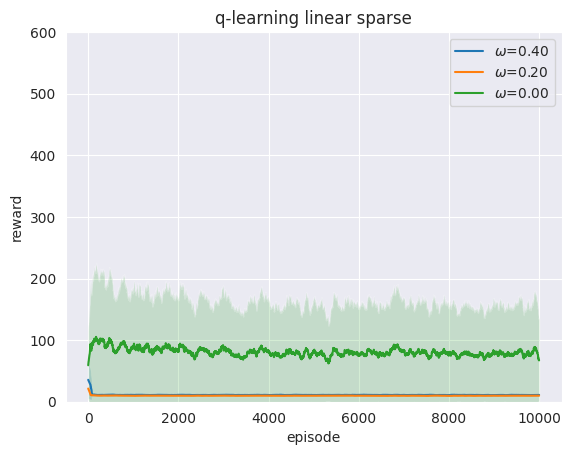

Reward: 71.71666666666665 ± 58.60499616184854
Scale of discretization:  5
N0 for the epsilon-greedy:  25.0
Gamma:  0.95
Difference between the lower bound from the confidence interval:  0.0
Difference between the lower bound from the confidence interval:  -1.4645623278668563
Difference between the lower bound from the confidence interval:  -1.6194378525909983


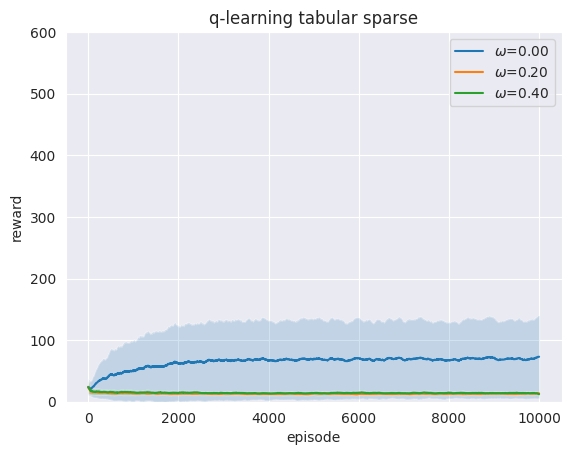

Reward: 385.6699999999999 ± 35.21257333755395
Scale of discretization:  20
N0 for the epsilon-greedy:  5.0
Gamma:  0.5
Difference between the lower bound from the confidence interval:  0.0
Difference between the lower bound from the confidence interval:  -322.96291553280116
Difference between the lower bound from the confidence interval:  -330.6278252042659


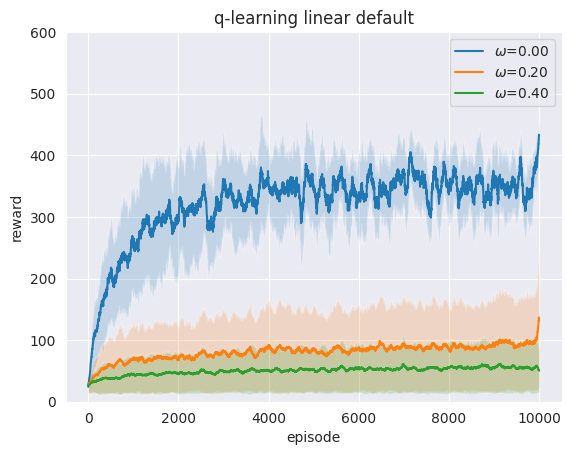

Reward: 190.36333333333334 ± 41.174083248921676
Scale of discretization:  5
N0 for the epsilon-greedy:  10.0
Gamma:  0.5
Difference between the lower bound from the confidence interval:  0.0
Difference between the lower bound from the confidence interval:  -56.09706830604408
Difference between the lower bound from the confidence interval:  -94.77028919501775


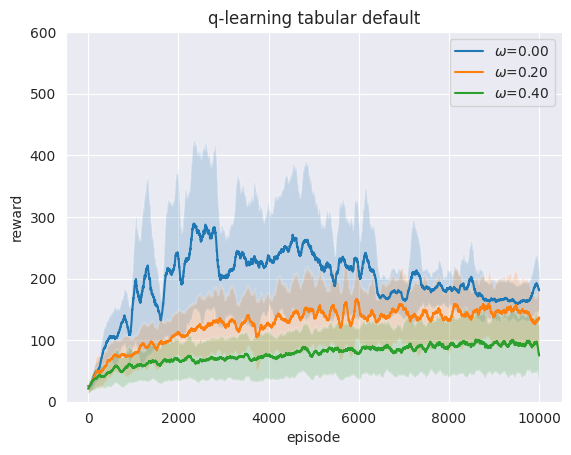

Reward: 259.94666666666666 ± 182.6985467896887
Scale of discretization:  5
N0 for the epsilon-greedy:  10.0
Gamma:  0.95
Difference between the lower bound from the confidence interval:  0.0
Difference between the lower bound from the confidence interval:  -67.64045441635402
Difference between the lower bound from the confidence interval:  -102.35648673912729


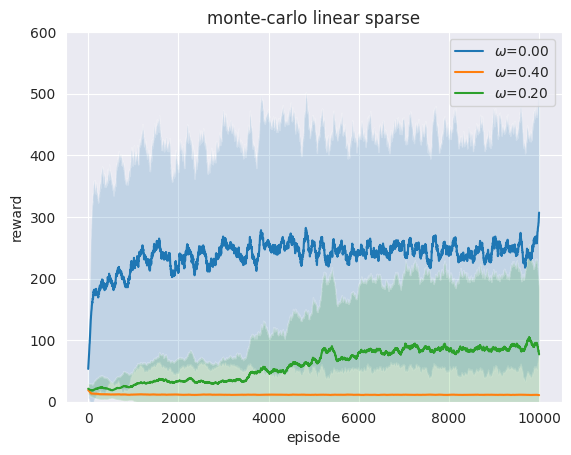

Reward: 22.52 ± 4.31227461041391
Scale of discretization:  5
N0 for the epsilon-greedy:  2.0
Gamma:  0.95
Difference between the lower bound from the confidence interval:  0.0
Difference between the lower bound from the confidence interval:  -0.3780400683774303
Difference between the lower bound from the confidence interval:  -3.0848602528023825


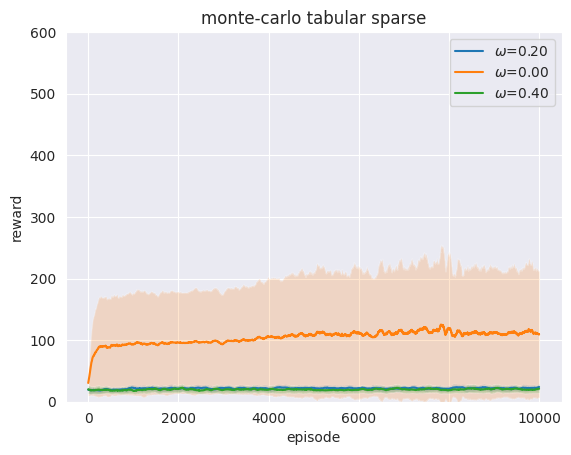

Reward: 408.55666666666673 ± 16.453034071910096
Scale of discretization:  5
N0 for the epsilon-greedy:  10.0
Gamma:  0.5
Difference between the lower bound from the confidence interval:  0.0
Difference between the lower bound from the confidence interval:  -352.0323191714497
Difference between the lower bound from the confidence interval:  -370.8609991394295


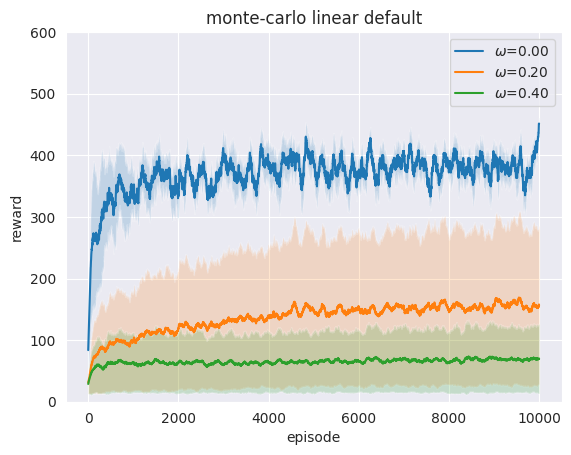

Reward: 413.12333333333333 ± 60.659467341503195
Scale of discretization:  20
N0 for the epsilon-greedy:  2.0
Gamma:  0.95
Difference between the lower bound from the confidence interval:  0.0
Difference between the lower bound from the confidence interval:  -222.3803239388901
Difference between the lower bound from the confidence interval:  -286.5230408127019


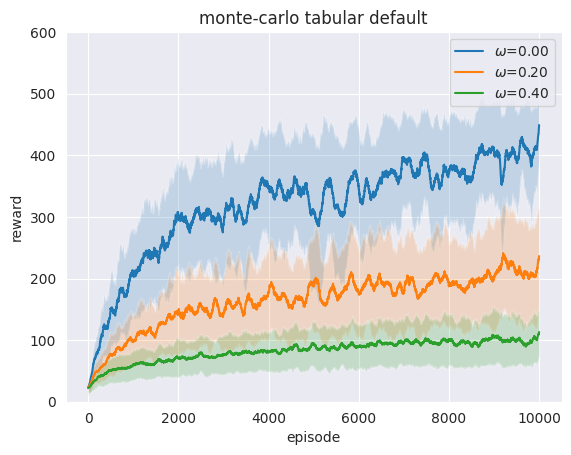

Reward: 500.0 ± 0.0
Scale of discretization:  2
N0 for the epsilon-greedy:  5.0
Lambda factor:  0.0
Gamma:  0.5
Difference between the lower bound from the confidence interval:  0.0
Difference between the lower bound from the confidence interval:  -482.4047653265957
Difference between the lower bound from the confidence interval:  -491.04380020854614


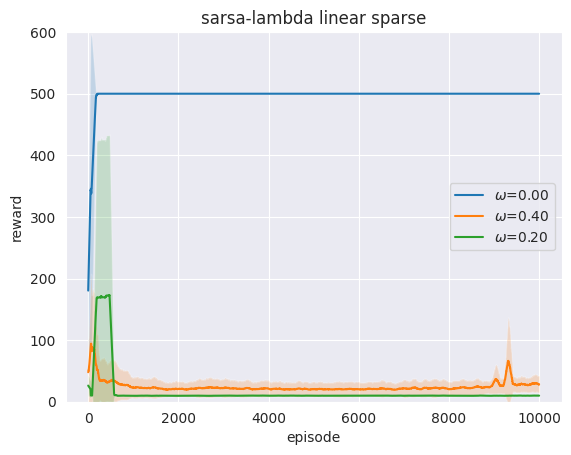

Reward: 22.13 ± 7.343937834464629
Scale of discretization:  2
N0 for the epsilon-greedy:  2.0
Lambda factor:  0.0
Gamma:  0.5
Difference between the lower bound from the confidence interval:  0.0
Difference between the lower bound from the confidence interval:  0.0
Difference between the lower bound from the confidence interval:  0.0


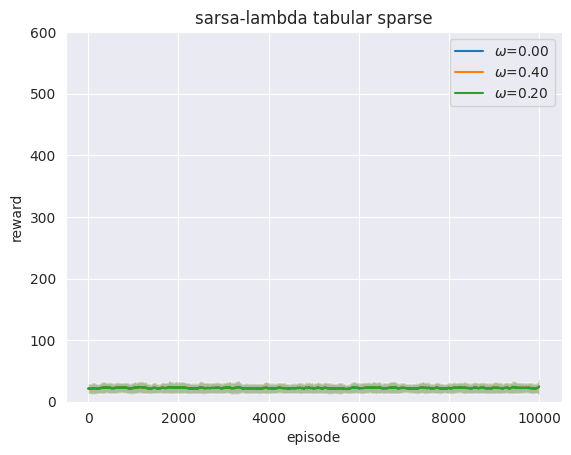

Reward: 289.76666666666665 ± 93.4234126036324
Scale of discretization:  2
N0 for the epsilon-greedy:  10.0
Lambda factor:  0.3
Gamma:  0.95
Difference between the lower bound from the confidence interval:  0.0
Difference between the lower bound from the confidence interval:  -110.43752355256164
Difference between the lower bound from the confidence interval:  -167.44703625175774


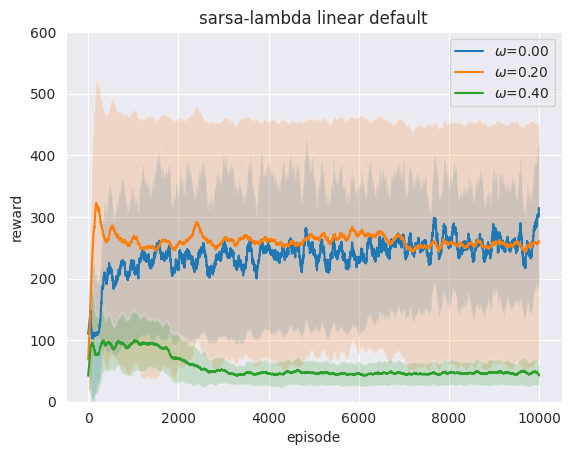

Reward: 22.13 ± 7.343937834464629
Scale of discretization:  2
N0 for the epsilon-greedy:  2.0
Lambda factor:  0.3
Gamma:  0.5
Difference between the lower bound from the confidence interval:  0.0
Difference between the lower bound from the confidence interval:  0.0
Difference between the lower bound from the confidence interval:  -0.3362139862103657


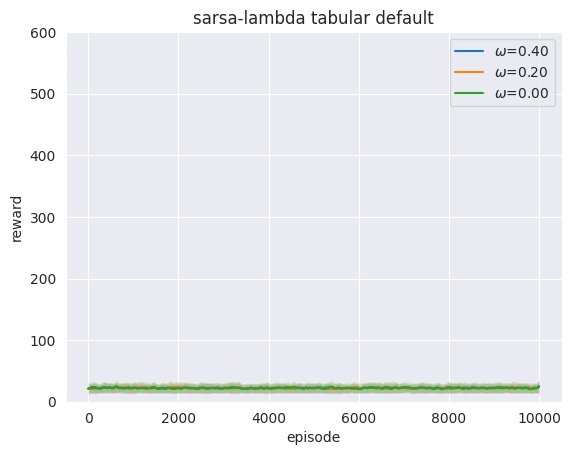

Reward: 19.9 ± 3.086136265473612
Scale of discretization:  1
Gamma:  0.99
Difference between the lower bound from the confidence interval:  0.0
Difference between the lower bound from the confidence interval:  -3.708299774314151
Difference between the lower bound from the confidence interval:  -5.739398432926963


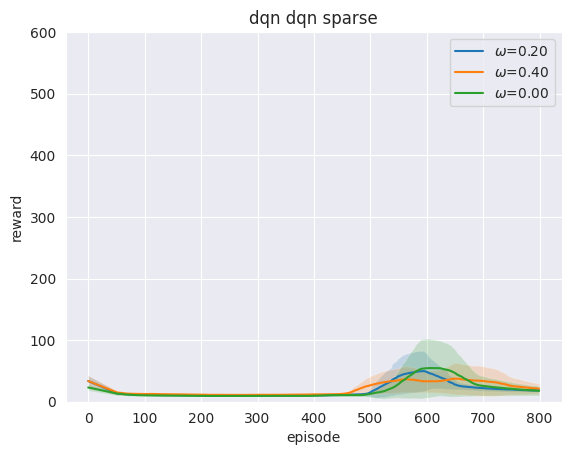

Reward: 474.9233333333333 ± 33.819034893902234
Scale of discretization:  1
Gamma:  0.99
Difference between the lower bound from the confidence interval:  0.0
Difference between the lower bound from the confidence interval:  -411.89755431530074
Difference between the lower bound from the confidence interval:  -424.1978083048845


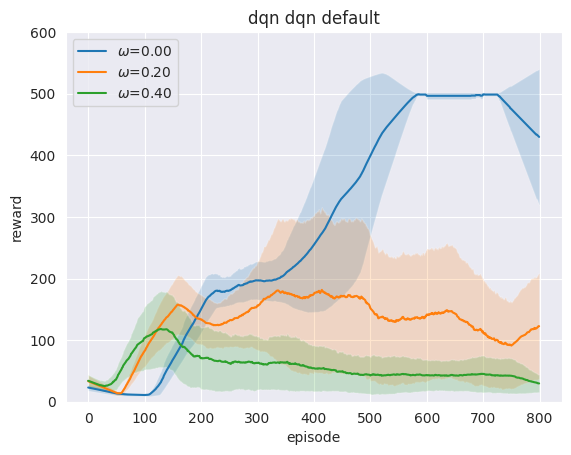

In [16]:
import matplotlib.pyplot as plt

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    # add padding to the signal
    y = np.pad(y, (box_pts//2, box_pts-1-box_pts//2), mode='edge')
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

configs = []

# get the row of maximum rewards of different methods
for method in ["q-learning", "monte-carlo", "sarsa-lambda",  "dqn"]:
    functions = ["linear", "tabular"] if method != "dqn" else ["dqn"]
    for reward_mode in ["sparse", "default"]:
            for function in functions:
                
                # get the best value
                best_val = df[(df["method"] == method) 
                              & (df["function"] == function) 
                              & (df["reward_mode"] == reward_mode)].sort_values(by=["lower_cfd"], ascending=False).iloc[0]
                
                m_ = np.array(best_val["mean_curve"][-100:]).mean()
                s_ = np.array(best_val["std_curve"][-100:]).mean()
                print(f"Reward: {m_} ± {s_}")
                print("Scale of discretization: ", best_val["discrete_scale"])
                if method != "dqn":
                    print("N0 for the epsilon-greedy: ", best_val["n0"])
                if method == "sarsa-lambda":
                    print("Lambda factor: ", best_val["lambda_factor"])
                print("Gamma: ", best_val["gamma"])
                
                
                # get the other executions with different stochasticity factor
                other_val = df[(df["method"] == method) 
                              & (df["function"] == function) 
                              & (df["reward_mode"] == reward_mode)
                              & (df["lambda_factor"] == best_val["lambda_factor"])
                              & (df["gamma"] == best_val["gamma"])
                                 & (df["n0"] == best_val["n0"])
                                 & (df["discrete_scale"] == best_val["discrete_scale"])].sort_values(by=["lower_cfd"], ascending=False)
                
                # iterate through other values
                for i in range(0, len(other_val)):
                    mean = other_val.iloc[i]["mean_curve"]
                    std = other_val.iloc[i]["std_curve"]
                    stochasticity_factor = other_val.iloc[i]["stochasticity_factor"]
                    print("Difference between the lower bound from the confidence interval: ", other_val.iloc[i]["lower_cfd"] - best_val["lower_cfd"])
                    
                    window = 100
                    mean = smooth(mean, window)
                    std = smooth(std, window)
                   
                    ci = 1.96 * std / np.sqrt(3)
                   
                    if reward_mode == "sparse":
                        plt.plot(mean, label=f"$\omega$={stochasticity_factor:.2f}")
                        plt.fill_between(range(len(mean)), mean-ci, mean+ci, alpha=0.2)
                    else:
                        plt.plot(mean, label=f"$\omega$={stochasticity_factor:.2f}")
                        plt.fill_between(range(len(mean)), mean-ci, mean+ci, alpha=0.2)
                    
                plt.legend()
                plt.title(f"{method} {function} {reward_mode}")
                plt.xlabel("episode")
                plt.ylabel("reward")
                plt.ylim(0, 600)
                plt.show()

# Discussion

There are several points to discuss.

First, there are a few considerations about the hyperparameters:
- The $\gamma$ discount factor does not contribute that much to the performance. 
- The discretization scale $N$ contributed negatively to the performance. I think that there increases the variance of the algorithm because it is harder to learn the Q function in the tabular case.
- The states visited generally are very sparse. It doesn't require that much exploration to generalize since we are mainly converging to a single state, where the pole is upright.
- $N_0$ for the $\epsilon$-greedy contributed negatively to the performance. I think that it is because the exploration is not that important. The agent can learn the optimal policy without that much exploration.
- The stochasticity factor $\omega$ hurts very badly the performance. I think that it is because the environment is very sensitive to the actions. A small change in the action can make the pole fall. So, the agent has to be very precise in the actions. However, the stochasticity factor could enhance the agent robustness to the environment, but to test that hypothesis, I would have to run experiments turning off the stochasticity.
- The $\lambda$ factor for the Sarsa($\lambda$) algorithm does not contribute that much to the performance. I think that it is because the environment is very sparse and focused on immediate reward. So, the agent does not need to learn the long-term dependencies. Generally, the optimal $\lambda$ is around 0.0 (Sarsa-0), which means that the agent is learning only the immediate reward.

Now, there are a few considerations about the algorithms in the context of a dense reward environment:
- Monte-carlo performed very well, both in the tabular and linear case. However, the linear case it had a smaller variance. I think that it is because the linear case is more robust to the environment. The tabular case is very sensitive to the environment. A small change in the environment can make the agent learn a completely different policy.
- Q-learning performed poorly in the tabular case, but relatively good in the linear case, but not so good as the monte-carlo.
- Sarsa($\lambda$) performed terrible, we almost can say it took random steps. The linear case it was better, with a mean reward close to the q-learning algorithm, but with a higher variance. One thing interesting noting is that even if stochasticity factor different from zero, the agent converged to the same experiment result without stochasticity, however with higher variance.
− DQN performed very well. In almost all experiments it remained with a mean reward of 500 (the truncation value).

Now, there are a few considerations about the algorithms in the context of a sparse reward environment:
- The optimal $\gamma$'s are different from the dense reward environment. In the sparse reward environment, the optimal $\gamma$ was 0.95. I think that it is because the environment is sparse, so the agent has to learn the long-term dependencies. However, I think it should be a little higher, but I did not have time to run more experiments.
- Monte-carlo performed poorly, both in the tabular and linear case. However, the linear case was a little better, but with high variance. 
- Q-learning did not converge at all. I think that it is because the environment is sparse, so the agent has to learn the long-term dependencies. However, the q-learning algorithm is more suitable for short-term dependencies. It learns the immediate reward. So, it does not converge.
− Sarsa($\lambda$) performed extremely well in the linear case, it is the best in all experiments, even comparing to the dense reward environment. The reason for that is a mystery for me and further experiments are necessary. However, in the tabular case it did not converge at all.
- DQN was terrible. It is almost like a random agent.

That is it. I hope you enjoy the report. I had a lot of fun doing it. I learned a lot about reinforcement learning.

### DQN on its 1000th iteration
![SegmentLocal](dqn-1000-it.gif "DQN on its 1000th iteration")